In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
pd.set_option('future.no_silent_downcasting', True)

In [18]:
df = pd.read_csv("studies.csv", sep=";")
df

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
0,Acute Exacerbation of a Chronic Obstructive Pu...,"Wu, CT",2021,CO,NaN,DE,67,TREE,RF,TAI,...,0.986,0.8770,0.9550,0.9140,T,N,M,"DS, MDI",k-fold,Random forest result (Table 3 first row)
1,A smart healthcare-based system for classifica...,"Lim, J",2022,DEM,NaN,DR,18,DNN,DNN,SK,...,0.997,0.9658,0.9895,0.9844,T,N,M,FS,N,Deep neural network with quantile scaler resul...
2,Continuous Wearable Monitoring Analytics Predi...,"Stehlik, J.",2020,HD,HF,DH,100,SBM,NaN,USA,...,0.893,0.8750,0.8600,NaN,F,N,M,N,N,Event-specific window HF hospitalization resul...
3,Evaluating the Potential of Machine Learning a...,"Liu, Jen-Hsuan",2023,CAN,NaN,DM,40,TREE,XGB,TAI,...,0.960,NaN,0.9700,0.9300,T,UR,M,"MDI, DS, FE, FS",k-fold,NaN
4,A Decision Support System for Tele-Monitoring ...,"Merone, M.",2017,CO,NaN,DE,22,PN,NaN,IT,...,NaN,0.9930,NaN,0.9840,F,N,D,N,LOOCV,Only one result reported (Table 2 first row)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,Combining patient-reported outcome measures to...,"Looijen, Agnes E M",2024,RA,NaN,DS,1208,LG,NaN,NL,...,0.759,NaN,NaN,NaN,T,UR,L,N,B,Results Test characteristics and discriminativ...
72,Wearable-Enabled Algorithms for the Estimation...,"Crowe, Colum",2024,PD,NaN,DE,24,DNN,CNN,USA,...,0.650,NaN,NaN,0.6300,F,N,M,"DA, FE, SD",k-fold,Table 4. Bradykinesia
73,Machine learning for prediction of ventricular...,"Cha, Yong-Mei",2024,HD,NaN,DD,13516,DNN,CNN,USA,...,0.830,NaN,NaN,NaN,F,N,M,N,N,Results Short-range prediction
74,Artificial intelligence based real-time predic...,"Hinrichs, N",2024,HD,HF,DH,1538,DNN,DNN,DE,...,0.855,NaN,NaN,NaN,T,UR,M,"MDI, FE, FS",EX,Results Prediction of unplanned HF hospitalisa...


# Helper functions

In [19]:
def col_value_count(col, df=df):
    dtype = df[col].dtype
    if dtype == "O":
        all_params = []
        param_count = []
        for i, row in df.iterrows():
            str_val = str(row[col])
            study_params = str_val.split(",")
            for param in study_params:
                param = param.strip()
                if param in all_params:
                    param_index = all_params.index(param)
                    param_count[param_index] += 1
                else:
                    all_params.append(param)
                    param_count.append(1)
        df_count = pd.DataFrame({col:all_params, "Count":param_count}).sort_values(by='Count', ascending=False)
    else:
        df_count = pd.DataFrame(df[col].value_counts())    
    return df_count

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val}'
    return my_autopct

def group_by_col(col, grouping_col):
    condition_param_df = pd.DataFrame()
    for condition in df[grouping_col].unique():
        condition = condition.strip()
        df_selected = df[df[grouping_col]==condition]
        all_params = []
        param_count = []
        for i, row in df_selected.iterrows():
            study_params = row[col].split(",")
            for param in study_params:
                param = param.strip()
                if param in all_params:
                    param_index = all_params.index(param)
                    param_count[param_index] += 1
                else:
                    all_params.append(param)
                    param_count.append(1)
        condition_param_df = pd.concat([condition_param_df, pd.DataFrame({grouping_col:condition, col:all_params, "Count":param_count})])
    return condition_param_df

# Risk of bias assessment

In [20]:
rob_table = pd.read_csv("RoB_table.csv", sep=";")

In [21]:
rob_table['Development vs Validation'].value_counts()

Development vs Validation
D     67
DV     8
V      1
Name: count, dtype: int64

In [22]:
rob_table[rob_table['Development vs Validation']=='V']

,Title,First Author,Year,Diagnostic vs Prognostic,Development vs Validation,Participants 1.1,Participants 1.2,Participants RoB,Predictors 2.1,Predictors 2.2,...,Analysis 4.2,Analysis 4.3,Analysis 4.4,Analysis 4.5,Analysis 4.6,Analysis 4.7,Analysis 4.8,Analysis 4.9,Analysis RoB,Overall RoB
2,Continuous Wearable Monitoring Analytics Predi...,"Stehlik, J",2020,P,V,Y,Y,L,Y,Y,...,Y,Y,PY,X,Y,Y,X,X,H,H


In [23]:
rob_table['Diagnostic vs Prognostic'].value_counts()

Diagnostic vs Prognostic
D    56
P    20
Name: count, dtype: int64

In [24]:
for domain in ['Participants', 'Predictors', 'Outcome', 'Analysis', 'Overall']:
    domain_counts = rob_table[domain + ' RoB'].value_counts()
    print(domain_counts)

Participants RoB
L    67
H     6
U     3
Name: count, dtype: int64
Predictors RoB
L    72
U     2
H     2
Name: count, dtype: int64
Outcome RoB
L    53
H    19
U     4
Name: count, dtype: int64
Analysis RoB
H    53
L    17
U     6
Name: count, dtype: int64
Overall RoB
H    56
L    14
U     6
Name: count, dtype: int64


In [26]:
rob_table.head()

,Title,First Author,Year,Diagnostic vs Prognostic,Development vs Validation,Participants 1.1,Participants 1.2,Participants RoB,Predictors 2.1,Predictors 2.2,...,Analysis 4.2,Analysis 4.3,Analysis 4.4,Analysis 4.5,Analysis 4.6,Analysis 4.7,Analysis 4.8,Analysis 4.9,Analysis RoB,Overall RoB
0,Acute Exacerbation of a Chronic Obstructive Pu...,"Wu, C",2021,P,D,Y,Y,L,Y,Y,...,Y,Y,PY,Y,Y,Y,Y,Y,L,H
1,A smart healthcare-based system for classifica...,"Lim, J",2022,D,D,Y,N,H,Y,Y,...,Y,Y,Y,Y,Y,Y,N,Y,H,H
2,Continuous Wearable Monitoring Analytics Predi...,"Stehlik, J",2020,P,V,Y,Y,L,Y,Y,...,Y,Y,PY,X,Y,Y,X,X,H,H
3,Evaluating the Potential of Machine Learning a...,"Liu, J",2023,P,D,Y,Y,L,Y,Y,...,Y,N,Y,Y,Y,Y,Y,Y,L,L
4,A Decision Support System for Tele-Monitoring ...,"Merone, M",2017,P,D,Y,U,U,Y,Y,...,Y,Y,Y,Y,Y,Y,Y,Y,H,H


In [27]:
new_cols = rob_table.columns[:5].tolist() + ['1.1', '1.2', 'Part. RoB', '2.1', '2.2', '2.3', 'Pred. RoB', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', 'Outc. RoB', '4.1', '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', 'Anal. RoB', 'Overall RoB']
rob_table.columns = new_cols

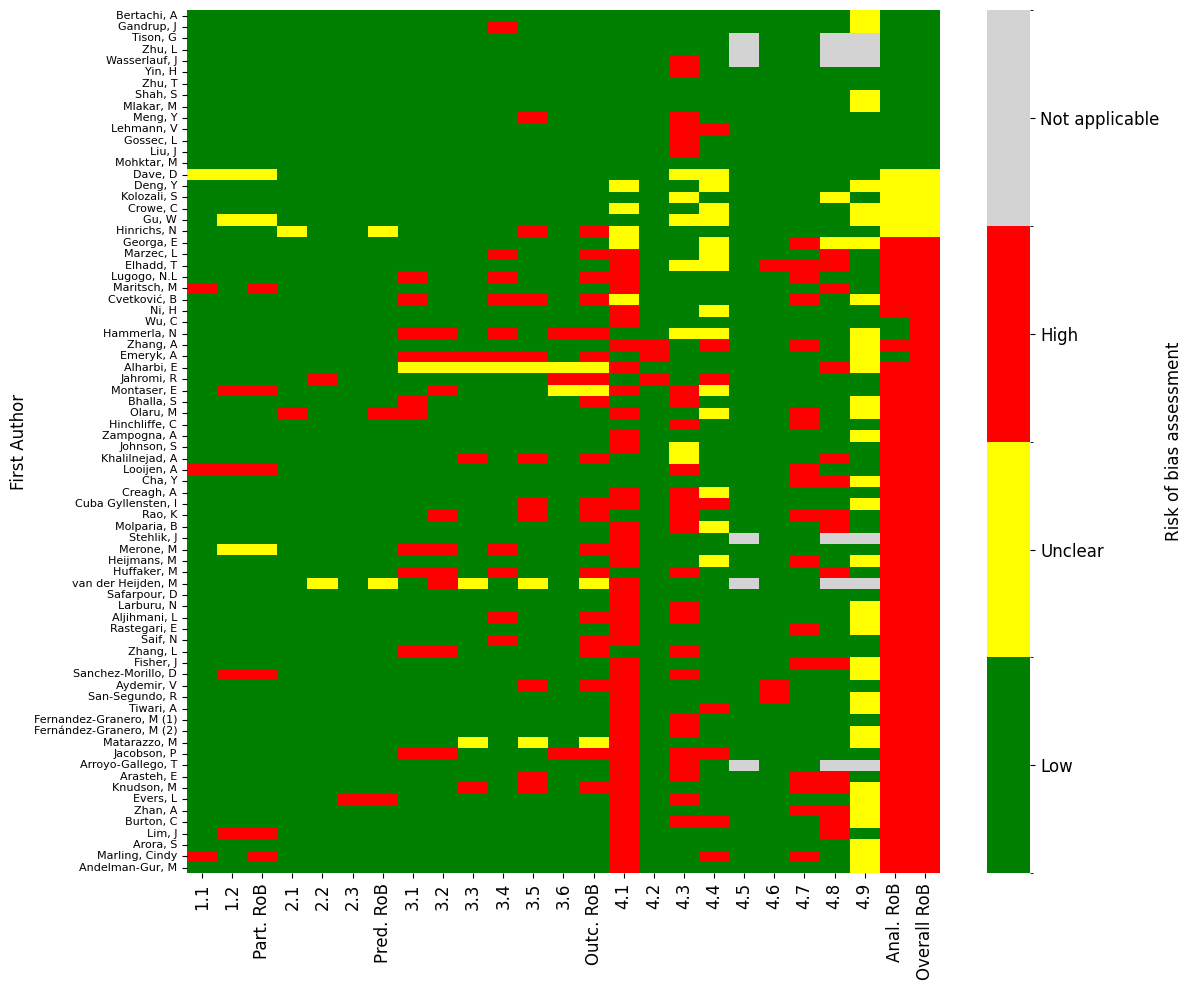

In [28]:
# Select columns starting from 'Participants 1.1' onwards
rob_columns = rob_table.columns.tolist()
data_cols = rob_columns[5:]
rob_data = rob_table[data_cols]

# Define a mapping from categorical entries to numerical values
category_mapping = {
    # Not Applicable
    'X': 0,
    # High Risk
    'N': 1,
    'PN': 1,
    'H': 1,
    # Unclear Risk
    'U': 2,
    # Low Risk
    'Y': 3,
    'PY': 3,
    'L': 3
}

# Apply the mapping to the data and explicitly handle downcasting
rob_data_mapped = rob_data.replace(category_mapping).infer_objects(copy=False)

# Convert all data to numeric, coercing errors to NaN
rob_data_numeric = rob_data_mapped.apply(pd.to_numeric, errors='coerce')

# Set the index to 'First Author' or another identifier for labeling
rob_data_numeric.index = rob_table['First Author'].str.rstrip('.')

rob_data_numeric = rob_data_numeric.sort_values('Overall RoB', ascending=False)

# Define discrete colormap with four colors (grey, red, yellow, green)
cmap = ListedColormap(['lightgrey', 'red', 'yellow', 'green'])
bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, cmap.N)

# Create a mapping from numerical values to category labels for the colorbar
colorbar_labels = ['Not applicable', 'High', 'Unclear', 'Low']

# Create figure with fixed size
plt.figure(figsize=(12, 10))

# Create the heatmap with adjusted font sizes
heatmap = sns.heatmap(
    rob_data_numeric,
    cmap=cmap,
    norm=norm,
    annot=False,
    cbar_kws={
        'label': 'Risk of bias assessment',
        'ticks': [0.5, 1.5, 2.5, 3.5]  
    },
    yticklabels=rob_data_numeric.index
)

# Adjust font sizes
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=8)

# Set custom tick labels for the colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticklabels(colorbar_labels)
colorbar.ax.invert_yaxis()
colorbar.ax.tick_params(labelsize=12)
colorbar.ax.set_ylabel('Risk of bias assessment', fontsize=12)

plt.ylabel('First Author', fontsize=12)
plt.tight_layout()

# Save the heatmap
plt.savefig('images/risk_of_bias_heatmap.eps', format='eps')
plt.show()

In [29]:
# Display the top 10 columns with the highest combined count of 'N' and 'PN'
combined_counts = rob_table.apply(lambda col: (col == 'N').sum() + (col == 'PN').sum())
top10_combined = combined_counts.sort_values(ascending=False).head(10)
print("Top 10 columns with highest combined count of 'N' and 'PN':")
print(top10_combined)

Top 10 columns with highest combined count of 'N' and 'PN':
4.1    43
4.3    26
4.7    17
4.8    15
3.4    10
3.1    10
3.5    10
3.2     9
4.4     8
1.2     4
dtype: int64


In [30]:
rob_table['Development vs Validation'].value_counts()

Development vs Validation
D     67
DV     8
V      1
Name: count, dtype: int64

In [31]:
rob_table['Diagnostic vs Prognostic'].value_counts()

Diagnostic vs Prognostic
D    56
P    20
Name: count, dtype: int64

In [32]:
rob_table['Anal. RoB'].value_counts()

Anal. RoB
H    53
L    17
U     6
Name: count, dtype: int64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


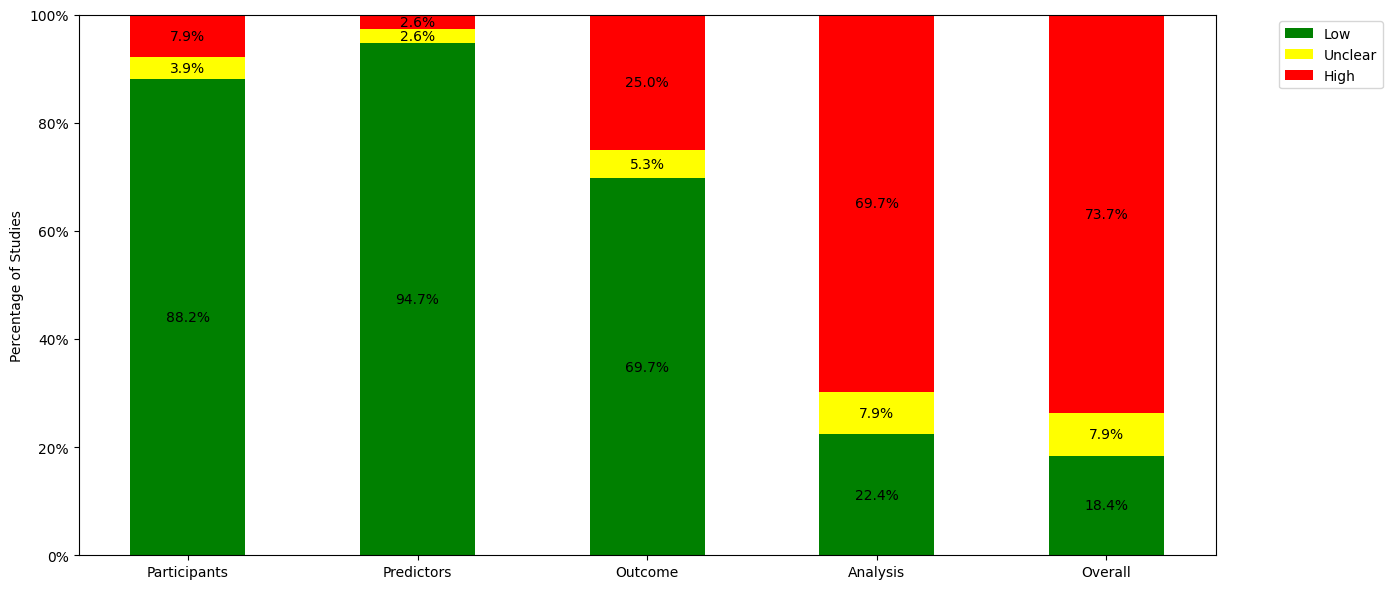

In [33]:
robs = rob_table[['Part. RoB', 'Pred. RoB', 'Outc. RoB', 'Anal. RoB', 'Overall RoB']]
robs.columns = ['Participants', 'Predictors', 'Outcome', 'Analysis', 'Overall']
risk_counts = {
    'Participants': {'L': 0, 'U': 0, 'H': 0},
    'Predictors': {'L': 0, 'U': 0, 'H': 0},
    'Outcome': {'L': 0, 'U': 0, 'H': 0},
    'Analysis': {'L': 0, 'U': 0, 'H': 0},
    'Overall': {'L': 0, 'U': 0, 'H': 0}
}

# Count the occurrences of each risk level for each domain
for _, row in robs.iterrows():
    for domain in risk_counts.keys():
        risk_level = row[domain]
        if risk_level in risk_counts[domain]:
            risk_counts[domain][risk_level] += 1

# Create a DataFrame from the risk_counts dictionary
df_risk = pd.DataFrame(risk_counts)

# Calculate percentages
df_risk_pct = df_risk.apply(lambda x: x / x.sum() * 100)

# Set up the plot
fig, ax = plt.subplots(figsize=(14, 6))  # Increased width to accommodate legend

# Create the stacked bar chart
bar_width = 0.5
index = np.arange(len(df_risk_pct.columns))

ax.bar(index, df_risk_pct.loc['L'], bar_width, label='Low', color='green')
ax.bar(index, df_risk_pct.loc['U'], bar_width, bottom=df_risk_pct.loc['L'], label='Unclear', color='yellow')
ax.bar(index, df_risk_pct.loc['H'], bar_width, bottom=df_risk_pct.loc['L'] + df_risk_pct.loc['U'], label='High', color='red')

# Customize the plot
ax.set_ylabel('Percentage of Studies')
ax.set_xticks(index)
ax.set_xticklabels(df_risk_pct.columns, rotation=0, ha='center')

# Move legend outside of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels
for i in index:
    for j, risk in enumerate(['L', 'U', 'H']):
        height = df_risk_pct.iloc[j, i]
        if height > 0:
            if j == 0:
                y = height / 2
            elif j == 1:
                y = df_risk_pct.iloc[0, i] + height / 2
            else:
                y = df_risk_pct.iloc[0, i] + df_risk_pct.iloc[1, i] + height / 2
            ax.text(i, y, f'{height:.1f}%', ha='center', va='center')

# Set y-axis to percentage scale
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticklabels([f'{i}%' for i in range(0, 101, 20)])

plt.savefig('images/rob_domains.eps', format='eps')
plt.tight_layout()
plt.show()

# General study characteristics

In [34]:
len(df)

76

In [35]:
year_count = col_value_count("Year").sort_values("Year")
year_df = year_count.reset_index()
year_df.columns = ['Year', 'Counts']
year_df

,Year,Counts
0,2014,3
1,2015,6
2,2016,6
3,2017,3
4,2018,9
5,2019,4
6,2020,11
7,2021,3
8,2022,7
9,2023,11


In [36]:
year_count_after_2017 = np.sum(year_df.loc[year_df['Year'].isin([2020, 2021, 2022, 2023, 2024]),'Counts'])
year_count_after_2017

45

In [37]:
years = year_count.index
counts = year_count.iloc[:, 0]
years_sorted, counts_sorted = zip(*sorted(zip(years, counts), key=lambda x: x[0]))

In [38]:
countries_studies = col_value_count("Country")
countries_studies

,Country,Count
2,USA,25
5,UK,10
7,SP,8
4,NL,6
0,TAI,3
9,CH,3
15,CN,3
12,CA,2
10,SL,2
8,Q,2


In [39]:
european_countries = ['SP', 'NL', 'GR', 'SL', 'SW', 'FR', 'SK', 'DK', 'IT', 'PL', 'DE']
middle_east_countries = ['Q', 'SA']
me_count = np.sum(countries_studies.loc[countries_studies['Country'].isin(middle_east_countries), 'Count'])
eu_count = np.sum(countries_studies.loc[countries_studies['Country'].isin(european_countries), 'Count'])
countries_studies = countries_studies[~countries_studies['Country'].isin(european_countries) & ~countries_studies['Country'].isin(middle_east_countries)]
eu_df = pd.DataFrame({'Country': ['European Union'], 'Count': [eu_count]})
me_df = pd.DataFrame({'Country': ['ME'], 'Count': [me_count]})
countries_studies = pd.concat([eu_df, me_df, countries_studies])

countries_studies.sort_values('Count', ascending=False, inplace=True)
countries_studies.columns = ['Region', 'Count']

# Disease outcomes

In [40]:
condition_df = col_value_count("Condition")
condition_df

,Condition,Count
4,PD,22
7,DI,15
0,CO,14
2,HD,13
6,RA,6
5,AST,4
1,DEM,1
3,CAN,1
8,HT,1


In [41]:
df[df['Subcondition']=='AF']

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
29,Passive Detection of Atrial Fibrillation Using...,"Tison, GH",2018,HD,AF,DD,183,DNN,DNN,USA,...,0.72,0.677,0.676,NaN,T,N,M,N,EX,Results section Analysis of Ambulatory AF Dete...
30,Atrial Fibrillation Detection and Atrial Fibri...,"Zhu, L",2022,HD,AF,DD,204,HM,NaN,USA\n,...,NaN,0.878,0.974,NaN,F,N,M,SD,EX,Results section Characterizing Algorithm perfo...
31,Smartwatch Performance for the Detection and Q...,"Wasserlauf, J",2019,HD,AF,DD,24,DNN,CNN,USA,...,NaN,0.977,0.989,NaN,F,N,M,N,N,Duration sensitivity (Results)


In [42]:
df['Labeling'].value_counts()

Labeling
PRO        24
PM         11
MD         10
VT          7
E           6
F           6
EL          4
E, PRO      3
PRO, E      1
MD\n        1
VT, PRO     1
MD, VT      1
PRO, VT     1
Name: count, dtype: int64

In [43]:
col_value_count('Subcondition')

,Subcondition,Count
0,nan,49
2,DI1,9
1,HF,7
3,DI,4
4,AF,3
5,DI2,2
6,HD,1
7,VT,1


In [44]:
outcomes_df = col_value_count("Outcomes")
outcomes_df

,Outcomes,Count
0,DE,40
5,DD,16
4,DS,11
6,WB,4
7,MS,4
1,DR,3
2,DH,2
3,DM,1


In [45]:
cond_outc_df = pd.DataFrame()
for condition in df.Condition.unique():
    df_filtered = df[df["Condition"]==condition]
    counts = col_value_count("Outcomes", df_filtered)
    counts["Condition"] = condition
    cond_outc_df = pd.concat([cond_outc_df, counts])
cond_outc_df.sort_values(by="Count", ascending=False, inplace=True)

cond_outc_df['Condition-Outcome combination'] = cond_outc_df['Condition'].astype(str) + '-' + cond_outc_df['Outcomes'].astype(str)
cond_outc_df = cond_outc_df[:12]
cond_outc_df

,Outcomes,Count,Condition,Condition-Outcome combination
0,DE,13,CO,CO-DE
0,DE,13,DI,DI-DE
2,DD,8,PD,PD-DD
0,DE,6,PD,PD-DE
1,DS,6,PD,PD-DS
2,DD,6,HD,HD-DD
0,DE,4,AST,AST-DE
3,MS,4,PD,PD-MS
1,DR,2,DI,DI-DR
2,DS,2,RA,RA-DS


In [46]:
labeling_df = col_value_count("Labeling")
labeling_df['Labeling'] = ['Patient reported outcomes', 'Medical diagnosis', 'Event outcomes', 'Clinical test results', 'Parallel measurement', 'Forecasting', 'Expert labeling']
labeling_df

,Labeling,Count
0,Patient reported outcomes,30
4,Medical diagnosis,12
5,Event outcomes,11
1,Clinical test results,10
2,Parallel measurement,10
6,Forecasting,6
3,Expert labeling,4


In [47]:
df['Labeling'].value_counts()

Labeling
PRO        24
PM         11
MD         10
VT          7
E           6
F           6
EL          4
E, PRO      3
PRO, E      1
MD\n        1
VT, PRO     1
MD, VT      1
PRO, VT     1
Name: count, dtype: int64

# Dataset size


In [48]:
dataset_size_numeric = pd.to_numeric(df["Dataset size"], errors='coerce')
dataset_size_numeric.sort_values()

41         1
18         1
54         1
22         6
58         6
       ...  
46       298
71      1208
74      1538
73     13516
69    200000
Name: Dataset size, Length: 76, dtype: int64

In [49]:
df.loc[df['Dataset size'] == df['Dataset size'].max()]

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
69,Proactive Identification of Patients with Diab...,"Khalilnejad, A",2024,DI,DI,DR,200000,TREE,LGB,USA,...,0.986,NaN,0.962,0.956,T,UR,M,"FE, FS, MDI",N,"Multimedia Appendix 2, Month 11 test set"


In [50]:
np.min(dataset_size_numeric)

1

In [51]:
np.mean(dataset_size_numeric)

2904.2368421052633

In [52]:
np.median(dataset_size_numeric.dropna())

37.5

In [53]:
np.std(dataset_size_numeric)

22811.032569598294

In [54]:
np.sum(dataset_size_numeric > 100)

19

In [55]:
df["Monitoring duration"].value_counts()

Monitoring duration
M     23
L     22
WS    12
W      9
?      5
D      5
Name: count, dtype: int64

In [56]:
df[df['Monitoring duration']=='?']

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
21,Classification of Decompensated Heart Failure ...,"Aydemir, Varol Burak",2020,HD,HF,DS,43,SVM,NaN,USA,...,0.778,NaN,NaN,NaN,T,N,D,"SD, FE, OD",LOOCV,RBF SVM (Table 5)
29,Passive Detection of Atrial Fibrillation Using...,"Tison, GH",2018,HD,AF,DD,183,DNN,DNN,USA,...,0.720,0.6770,0.6760,NaN,T,N,M,N,EX,Results section Analysis of Ambulatory AF Dete...
32,Detecting Motor Impairment in Early Parkinson'...,"Arroyo-Gallego, T",2018,PD,NaN,DD,52,EM,NaN,SP,...,0.760,0.7300,0.6900,NaN,F,N,L,FE,N,At-home (Table 2 second column)
52,Deep transfer learning and data augmentation i...,"Deng, Yixiang",2021,DI,DI2,DE,40,DNN,CNN,USA,...,NaN,0.5919,0.9815,0.9598,F,DA,M,"FE, DA, SD",LOOCV,Table 1b
60,Adaptive Smart eHealth Framework for Personali...,"Alharbi, E",2023,AST,NaN,DE,10,TREE,XGB,SA,...,NaN,NaN,NaN,0.9800,F,N,D,"MDI, OD, DS",N,Results and Discussion Prediction Models Perfo...


In [57]:
col_value_count('Remote data sources')

,Remote data sources,Count
1,WEAR,53
2,QU,20
3,AMD,20
0,ENV,5


In [58]:
df[df['Remote data sources'].str.contains('ENV')]

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
0,Acute Exacerbation of a Chronic Obstructive Pu...,"Wu, CT",2021,CO,NaN,DE,67,TREE,RF,TAI,...,0.986,0.877,0.955,0.9140,T,N,M,"DS, MDI",k-fold,Random forest result (Table 3 first row)
6,Passive Nocturnal Physiologic Monitoring Enabl...,"Huffaker, MF",2018,AST,NaN,DE,16,TREE,RF,USA,...,NaN,0.472,0.963,0.8740,T,N,M,FE,N,Only one result reported (Table 3)
8,Early detection of COPD patients' symptoms wit...,"Kolozali, S",2023,CO,NaN,DE,106,PLCA,NaN,UK,...,NaN,NaN,NaN,NaN,T,DA,M,"SD, FE",N,No classification features reported
15,Mining telemonitored physiological data and pa...,"Mlakar, Miha",2018,HD,HF,WB,24,TREE,RF\n,SL,...,0.790,NaN,NaN,0.8678,T,N,M,"FE, FS, MDI",k-fold,"Random forest (Table 6 sixth row for accuracy,..."
60,Adaptive Smart eHealth Framework for Personali...,"Alharbi, E",2023,AST,NaN,DE,10,TREE,XGB,SA,...,NaN,NaN,NaN,0.9800,F,N,D,"MDI, OD, DS",N,Results and Discussion Prediction Models Perfo...


In [59]:
df["Monitoring frequency"].value_counts()

Monitoring frequency
M    54
D    15
L     7
Name: count, dtype: int64

# Remote data sources and Parameters

In [60]:
col_value_count("Remote data sources")

,Remote data sources,Count
1,WEAR,53
2,QU,20
3,AMD,20
0,ENV,5


In [61]:
df_params = col_value_count("Parameters")
df_params

,Parameters,Count
7,ACC,33
3,HR,21
12,SYM,11
11,SPO2,10
14,LFP,8
9,EDA,7
17,W,6
18,ECG,6
22,GL,6
5,CC,6


In [62]:
len(df_params)

34

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


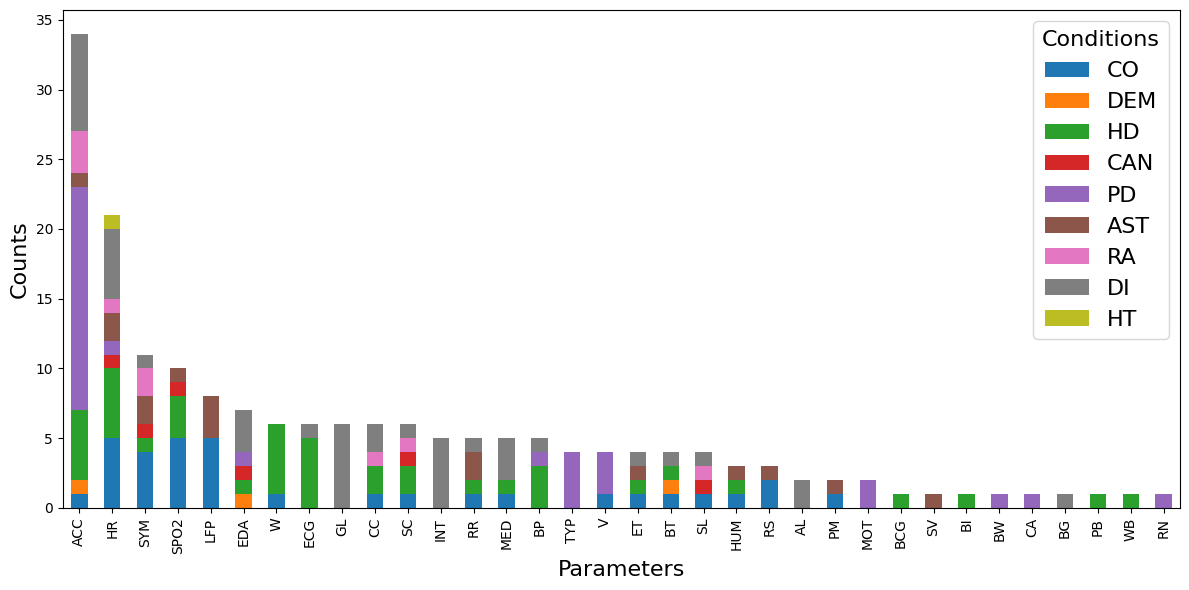

In [63]:
data = pd.DataFrame()
data["Params"] = col_value_count("Parameters").Parameters.unique()

conditions = df.Condition.unique()
for condition in conditions:
    data[condition] = 0
    condition_params = col_value_count("Parameters", df.loc[df["Condition"] == condition]).Parameters.values
    condition_param_count = col_value_count("Parameters", df.loc[df["Condition"] == condition]).Count.values
    for i, param in enumerate(condition_params):
        data.loc[data["Params"]==param,condition] = condition_param_count[i]

data.set_index('Params', inplace=True)

data.loc['ACC', ['PD', 'RA']] = data.loc['ACC', ['PD', 'RA']] + 1
data.drop('PD, RA', axis=1, inplace=True)
ax = data.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Parameters', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.legend(title='Conditions', fontsize=16, title_fontsize=16)
plt.tight_layout()
plt.savefig('images/parameters.eps', format='eps')
plt.show()

In [64]:
counts = []
for row in data.iterrows():
    param_cond_counts = row[1:][0]
    param_cond_counts = counts.append(np.sum(param_cond_counts!=0))
param_cond_count = pd.DataFrame({"Params": data.iloc[:, 0].index, "Count": counts}).sort_values(by="Count", ascending=False)
param_cond_count[:5]

,Params,Count
1,HR,8
0,ACC,7
2,SYM,6
5,EDA,5
10,SC,5


In [65]:
counts = []
for row in data.transpose().iterrows():
    param_cond_counts = row[1:][0]
    param_cond_counts = counts.append(np.sum(param_cond_counts!=0))
param_cond_count = pd.DataFrame({"Params": data.transpose().iloc[:, 0].index, "Count": counts}).sort_values(by="Count", ascending=False)
param_cond_count

,Params,Count
2,HD,19
0,CO,17
7,DI,17
5,AST,11
4,PD,10
3,CAN,6
6,RA,6
1,DEM,3
8,HT,1


# Algorithms

In [66]:
col_value_count("Algorithm")

,Algorithm,Count
0,TREE,19
1,DNN,15
4,LG,13
9,SVM,11
8,EM,3
5,BN,2
3,PN,1
6,PLCA,1
7,NB,1
2,SBM,1


In [67]:
df[df['Algorithm']=='EM']

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
12,Hand tremor-based hypoglycemia detection and p...,"Aljihmani, L",2022,DI,DI1,DE,32,EM,NaN,Q,...,NaN,NaN,0.6391,0.8605,F,N,M,"MDI, DS, FE",k-fold,EC model applying sequential classification 3 ...
32,Detecting Motor Impairment in Early Parkinson'...,"Arroyo-Gallego, T",2018,PD,NaN,DD,52,EM,NaN,SP,...,0.76,0.73,0.6900,NaN,F,N,L,FE,N,At-home (Table 2 second column)
45,Hypoglycemia Detection Using Hand Tremors: Hom...,"Jahromi, R.",2023,DI,DI1,DE,33,EM,NaN,USA,...,0.90,NaN,0.8455,0.8146,T,N,M,"SD, DS, FE",k-fold,Random forest 10-fold (table 2 third row)


In [68]:
col_value_count("Specific model")

,Specific model,Count
2,nan,42
0,RF,10
4,CNN,6
1,DNN,4
3,XGB,4
9,RNN,2
5,IF,1
6,PNN,1
7,RVNN,1
8,LightGBM,1


In [69]:
col_value_count("Model Interpreted")

,Model Interpreted,Count
0,T,38
1,F,38


In [70]:
col_value_count("Algorithm", df[df["Model Interpreted"]=='T'])

,Algorithm,Count
0,TREE,16
1,DNN,5
4,LG,5
5,SVM,5
2,BN,2
3,PLCA,1
6,CART,1
7,CCA,1
8,HMM,1
9,EM,1


In [71]:
col_value_count("Validation")

,Validation,Count
0,k-fold,35
1,N,19
2,LOOCV,15
5,EX,3
3,Other,2
4,Rolling CV,1
6,B,1


In [72]:
df[df['Validation']=='EX']

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
29,Passive Detection of Atrial Fibrillation Using...,"Tison, GH",2018,HD,AF,DD,183,DNN,DNN,USA,...,0.720,0.677,0.676,NaN,T,N,M,N,EX,Results section Analysis of Ambulatory AF Dete...
30,Atrial Fibrillation Detection and Atrial Fibri...,"Zhu, L",2022,HD,AF,DD,204,HM,NaN,USA\n,...,NaN,0.878,0.974,NaN,F,N,M,SD,EX,Results section Characterizing Algorithm perfo...
74,Artificial intelligence based real-time predic...,"Hinrichs, N",2024,HD,HF,DH,1538,DNN,DNN,DE,...,0.855,NaN,NaN,NaN,T,UR,M,"MDI, FE, FS",EX,Results Prediction of unplanned HF hospitalisa...


In [73]:
col_value_count("Data processing")

,Data processing,Count
4,FE,54
5,SD,20
3,N,15
2,FS,14
1,MDI,9
0,DS,7
6,OD,5
7,DA,4


In [74]:
df[df['Data processing'].str.contains('OD')]

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,AUC,SEN,SPE,ACC,Model Interpreted,Code availability,Monitoring frequency,Data processing,Validation,Metrics explanation
20,Predicting the risk of exacerbation in patient...,"Mohktar, Mas S",2015,CO,NaN,DE,21,CART,NaN,AU,...,NaN,0.611,0.804,0.718,T,N,D,"OD, FE",LOOCV,Results Multivariate classification section
21,Classification of Decompensated Heart Failure ...,"Aydemir, Varol Burak",2020,HD,HF,DS,43,SVM,NaN,USA,...,0.778,NaN,NaN,NaN,T,N,D,"SD, FE, OD",LOOCV,RBF SVM (Table 5)
38,Changes in telemonitored physiological variabl...,"Burton, Christopher",2014,CO,NaN,DE,19,LG,NaN,UK,...,NaN,NaN,NaN,NaN,T,N,D,"OD, FE",N,No classification metrics
60,Adaptive Smart eHealth Framework for Personali...,"Alharbi, E",2023,AST,NaN,DE,10,TREE,XGB,SA,...,NaN,NaN,NaN,0.980,F,N,D,"MDI, OD, DS",N,Results and Discussion Prediction Models Perfo...
65,Motor network gamma oscillations in chronic ho...,"Olaru, Maria",2024,PD,NaN,DE,16,LG,NaN,USA,...,NaN,NaN,NaN,NaN,F,UR,M,"OD, FE, SD",k-fold,Results Spectral peer of narrowband gamma osci...


In [75]:
col_value_count("Code availability")

,Code availability,Count
0,N,50
1,UR,18
2,DA,7
3,CA,1


In [76]:
col_value_count("Metrics")

,Metrics,Count
1,AUC,39
6,SPE,38
2,SEN,37
0,ACC,31
4,PRE,23
7,REC,20
5,F1,13
17,R2,8
13,MAE,4
11,P,4


In [77]:
df.loc[df['SEN']=='1; 1', 'SEN'] = 1
df['SEN'] = df['SEN'].astype(float)

In [78]:
df['Outcomes'] = df['Outcomes'].str.split(',').str[0].str.strip().str.replace('\n', '')
df['Monitoring_duration'] = df['Monitoring duration']
df['Monitoring_frequency'] = df['Monitoring frequency']
df['Labeling'] = df['Labeling'].str.split(',').str[0].str.strip().str.replace('\n', '')
df['Algorithm'] = df['Algorithm'].apply(lambda x: x if x in ['TREE', 'DNN', 'LG', 'SVM'] else 'Other')
df['Outcomes'] = df['Outcomes'].str.split(',').str[0].str.strip().str.replace('\n', '')
df['Outcomes'] = df['Outcomes'].apply(lambda x: x if x in ['DE', 'DD', 'DS'] else 'Other')
df['Validation'] = df['Validation'].apply(lambda x: x if x in ['k-fold', 'LOOCV', 'EX', 'N'] else 'Other')
df.loc[df['Validation']=='N', 'Validation'] = 'Simple'

In [79]:

bins = [0, 10, 50, 100, float('inf')]
labels =  ['10', '50', '100', '100+']

df['Dataset_size'] = pd.cut(df['Dataset size'], bins=bins, labels=labels, right=False)

In [80]:
bins = [2013, 2017, 2021, 2024]
labels = ['2014-2017', '2018-2021', '2022-2024']

# Group 'Year' into bins
df['Year'] = pd.cut(df['Year'], bins=bins, labels=labels, right=True)

In [81]:
df['Feature_engineering'] = 0

for index, row in df.iterrows():
    data_processing = row['Data processing']
    if 'FE' in data_processing:
        df.loc[index, 'Feature_engineering'] = 1

df['Signal_denoising'] = 0

for index, row in df.iterrows():
    data_processing = row['Data processing']
    if 'SD' in data_processing:
        df.loc[index, 'Signal_denoising'] = 1

df['Downsampling'] = 0

for index, row in df.iterrows():
    data_processing = row['Data processing']
    if 'DS' in data_processing:
        df.loc[index, 'Downsampling'] = 1

df['Feature_selection'] = 0

for index, row in df.iterrows():
    data_processing = row['Data processing']
    if 'FS' in data_processing:
        df.loc[index, 'Feature_selection'] = 1

# Performance comparison

In [82]:
# First, let's create a copy of the dataframe to avoid modifying the original
df_modified = df.copy()

# Find the row where Condition is 'PD, RA'
pd_ra_row = df_modified.loc[df_modified['Condition'] == 'PD, RA']

if not pd_ra_row.empty:
    # Create two new rows, one for PD and one for RA
    pd_row = pd_ra_row.copy()
    pd_row['Condition'] = 'PD'
    
    ra_row = pd_ra_row.copy()
    ra_row['Condition'] = 'RA'
    
    # Remove the original 'PD, RA' row
    df_modified = df_modified[df_modified['Condition'] != 'PD, RA']
    
    # Concatenate the new rows using pd.concat instead of append
    df_modified = pd.concat([df_modified, pd.DataFrame([pd_row.squeeze(), ra_row.squeeze()])], ignore_index=True)

# Reset the index if needed
df = df_modified.reset_index(drop=True)

In [83]:
characteristics = ['Condition', 'Algorithm', 'Dataset_size', 'Validation', 'Labeling', 'Outcomes', 'Year', 'Feature_engineering', 'Signal_denoising', 'Downsampling', 'Feature_selection']
metrics = ['SEN', 'SPE', 'ACC', 'AUC']

results = pd.DataFrame(index=metrics, columns=characteristics)
group_means_df = pd.DataFrame(index=metrics, columns=characteristics)
significant_pairs = {metric: {characteristic: [] for characteristic in characteristics} for metric in metrics}
metric_counts = []

for metric in metrics:
    for characteristic in characteristics:
        data = df[[characteristic, metric]].dropna()
        
        # Clean the metric column
        data[metric] = data[metric].apply(lambda x: np.nan if isinstance(x, str) and not x.replace('.', '', 1).isdigit() else x)
        data[metric] = data[metric].astype(float)
        
        if data.empty:
            results.loc[metric, characteristic] = '-'
            group_means_df.loc[metric, characteristic] = '-'
            continue

        unique_groups = data[characteristic].unique()
        group_means = data.groupby(characteristic)[metric].mean().to_dict()

        # Ensure all groups are represented, even if they have no data
        all_groups = df[characteristic].unique()

        # Reorder groups for specific characteristics
        if characteristic == 'Downsampling':
            all_groups = [0, 1]
        elif characteristic == 'Year':
            all_groups = ['2014-2017', '2018-2021', '2022-2024']
        elif characteristic == 'Dataset_size':
            all_groups = ['10', '50', '100', '100+']

        group_means_str = ', '.join([f"{group_means.get(group, '-'):0.2f}" if group in group_means else '-' for group in all_groups])
        group_means_df.loc[metric, characteristic] = group_means_str

        if len(unique_groups) > 2:
            model = ols(f'{metric} ~ C({characteristic})', data=data).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            p_value = anova_table.iloc[0, 3]
        else:
            group1, group2 = unique_groups
            group1_data = data[data[characteristic] == group1][metric]
            group2_data = data[data[characteristic] == group2][metric]
            
            # Check for sufficient data and variance
            if len(group1_data) < 2 or len(group2_data) < 2:
                print(f"Not enough data for t-test between {group1} and {group2} for {characteristic} - {metric}")
                p_value = np.nan
            elif group1_data.var() == 0 or group2_data.var() == 0:
                print(f"Zero variance in data for t-test between {group1} and {group2} for {characteristic} - {metric}")
                p_value = np.nan
            else:
                t_stat, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False, nan_policy='omit')

        count = len(data)
        if np.isnan(p_value):
            results.loc[metric, characteristic] = 'NaN'
            print(f"NaN p-value detected for characteristic: {characteristic}, metric: {metric}")
            print(f"Data: {data}")
            continue

        if p_value < 0.05:
            p_value_str = f"{p_value:.3f}"
            if p_value < 0.001:
                p_value_str = f"{p_value:.10f}".rstrip('0')
            results.loc[metric, characteristic] = f"\n\\textbf{{{p_value_str}}} *"
            if len(unique_groups) > 2:
                tukey = pairwise_tukeyhsd(endog=data[metric], groups=data[characteristic], alpha=0.05)
                for comparison in tukey.summary().data[1:]:
                    if comparison[-1] < 0.05:
                        group1_tukey, group2_tukey = comparison[0], comparison[1]
                        mean_diff = group_means[group1_tukey] - group_means[group2_tukey]
                        direction = ">" if mean_diff > 0 else "<"
                        significant_pairs[metric][characteristic].append(
                            (group1_tukey, group2_tukey, group_means[group1_tukey], group_means[group2_tukey], direction)
                        )
            else:
                mean1, mean2 = group1_data.mean(), group2_data.mean()
                direction = ">" if mean1 > mean2 else "<"
                significant_pairs[metric][characteristic].append(
                    (group1, group2, mean1, mean2, direction)
                )
        else:
            results.loc[metric, characteristic] = f"{p_value:.3f}"

    metric_counts.append(count)

results = results.transpose()
group_means_df = group_means_df.transpose()

In [84]:
results

,SEN,SPE,ACC,AUC
Condition,0.334,0.951,0.494,0.092
Algorithm,0.808,0.176,0.690,0.649
Dataset_size,0.710,0.852,0.913,0.476
Validation,0.817,0.452,0.167,0.309
Labeling,0.121,0.518,0.750,0.381
Outcomes,0.891,0.800,0.952,0.358
Year,0.529,0.746,0.505,0.072
Feature_engineering,\n\textbf{0.031} *,0.718,\n\textbf{0.0000171981} *,0.508
Signal_denoising,0.511,0.658,0.382,0.246
Downsampling,0.555,0.690,0.439,\n\textbf{0.010} *


In [85]:
# Merge results and group_means_df
final_results = results.copy()
for col in group_means_df.columns:
    final_results[col + '_means'] = group_means_df[col]


latex_table = """\\begin{table*}[h]
\\centering
\\caption{Association of study characteristics with performance metrics}
\\footnotesize
\\begin{tabular}{|p{0.175\\linewidth}|p{0.175\\linewidth}|p{0.175\\linewidth}|p{0.175\\linewidth}|p{0.175\\linewidth}|}\n\\hline\n
\\rowcolor{gray!25}"""
latex_table += "\\textbf{Study characteristic} & \\textbf{Sensitivity} & \\textbf{Specificity} & \\textbf{Accuracy} & \\textbf{AUC} \\\\\n\\hline\n"

for characteristic in characteristics:
    # Reorder groups for Downsampling and Year
    if characteristic == 'Downsampling':
        unique_groups = [0, 1]
    elif characteristic == 'Year':
        unique_groups = ['2014-2017', '2018-2021', '2022-2024']
    else:
        unique_groups = sorted([g for g in df[characteristic].unique() if str(g).lower() != 'other'])
        other_groups = [g for g in df[characteristic].unique() if str(g).lower() == 'other']
        unique_groups.extend(other_groups)
    
    unique_groups_str = ', '.join(map(str, unique_groups))
    row = f"{characteristic.replace('_', ' ')} \n ({unique_groups_str}) & "
    for metric in metrics:
        means = group_means_df.loc[characteristic, metric]
        p_value = results.loc[characteristic, metric]
        if isinstance(p_value, str) and float(p_value.strip('\\textbf{} *\n')) < 0.001:
            p_value = p_value.replace(p_value.strip('\\textbf{}*\n'), '$<$0.001')
        row += f"{means} \\newline (p={p_value}) & "
    row = row.rstrip(" & ") + " \\\\\n\\hline\n"
    latex_table += row

latex_table += "\\end{tabular}\n\\label{tab:performance_comparison}\n\\end{table*}"

print(latex_table)

\begin{table*}[h]
\centering
\caption{Association of study characteristics with performance metrics}
\footnotesize
\begin{tabular}{|p{0.175\linewidth}|p{0.175\linewidth}|p{0.175\linewidth}|p{0.175\linewidth}|p{0.175\linewidth}|}
\hline

\rowcolor{gray!25}\textbf{Study characteristic} & \textbf{Sensitivity} & \textbf{Specificity} & \textbf{Accuracy} & \textbf{AUC} \\
\hline
Condition 
 (AST, CAN, CO, DEM, DI, HD, HT, PD, RA) & 0.83, 0.97, 0.79, -, 0.77, 0.47, 0.78, 0.84, 0.78 \newline (p=0.334) & 0.80, 0.99, 0.89, 0.97, 0.85, 0.96, 0.89, 0.89, 0.89 \newline (p=0.951) & 0.87, 0.98, 0.81, 0.93, 0.81, 0.93, -, 0.89, 0.83 \newline (p=0.494) & 0.85, 1.00, 0.76, 0.96, 0.80, 0.88, 0.78, 0.89, - \newline (p=0.092) \\
\hline
Algorithm 
 (DNN, LG, SVM, TREE, Other) & 0.83, 0.76, 0.82, 0.74, 0.80 \newline (p=0.808) & 0.95, 0.91, 0.81, 0.75, 0.89 \newline (p=0.176) & 0.90, 0.84, 0.85, 0.83, 0.86 \newline (p=0.690) & 0.85, 0.81, 0.82, 0.77, 0.83 \newline (p=0.649) \\
\hline
Dataset size 
 (10, 100, 

In [86]:
for metric in metrics:
    for characteristic in characteristics:
        if significant_pairs[metric][characteristic]:
            print(f"Significant pairs for {metric} - {characteristic}:")
            for pair in significant_pairs[metric][characteristic]:
                group1, group2, mean1, mean2, direction = pair
                print(f"{group1} ({mean1:.3f}) {direction} {group2} ({mean2:.3f})")

Significant pairs for SEN - Feature_engineering:
0 (0.868) > 1 (0.760)
Significant pairs for SPE - Feature_selection:
0 (0.854) < 1 (0.942)
Significant pairs for ACC - Feature_engineering:
0 (0.969) > 1 (0.841)
Significant pairs for ACC - Feature_selection:
0 (0.845) < 1 (0.910)
Significant pairs for AUC - Downsampling:
1 (0.949) > 0 (0.811)
Significant pairs for AUC - Feature_selection:
0 (0.800) < 1 (0.881)


## Association of data processing methods with algorithms and parameters

In [87]:
acc_df = df[df['ACC'].notna()]

In [88]:
acc_df['Feature_engineering'].value_counts()

Feature_engineering
1    26
0     5
Name: count, dtype: int64

In [89]:
acc_df['ACC'].groupby(df['Feature_engineering']).mean()

Feature_engineering
0    0.969080
1    0.841312
Name: ACC, dtype: float64

In [90]:
acc_df['Outcomes'].groupby(acc_df['Feature_engineering']).value_counts()


Feature_engineering  Outcomes
0                    DE           3
                     DD           1
                     Other        1
1                    DE          14
                     DD           6
                     Other        5
                     DS           1
Name: count, dtype: int64

In [91]:
acc_df['Condition'].groupby(acc_df['Feature_engineering']).value_counts()


Feature_engineering  Condition
0                    CO            2
                     AST           1
                     DEM           1
                     PD            1
1                    DI           10
                     PD            7
                     CO            3
                     HD            3
                     AST           1
                     CAN           1
                     HT            1
Name: count, dtype: int64

In [92]:
acc_df['Validation'].groupby(acc_df['Feature_engineering']).value_counts()

Feature_engineering  Validation
0                    Simple         3
                     LOOCV          1
                     k-fold         1
1                    k-fold        14
                     LOOCV          9
                     Simple         3
Name: count, dtype: int64

In [93]:
acc_df.loc[(acc_df['Feature_engineering']==0)]

,Title,First Author,Year,Condition,Subcondition,Outcomes,Dataset size,Algorithm,Specific model,Country,...,Data processing,Validation,Metrics explanation,Monitoring_duration,Monitoring_frequency,Dataset_size,Feature_engineering,Signal_denoising,Downsampling,Feature_selection
0,Acute Exacerbation of a Chronic Obstructive Pu...,"Wu, CT",2018-2021,CO,NaN,DE,67,TREE,RF,TAI,...,"DS, MDI",k-fold,Random forest result (Table 3 first row),M,M,100,0,0,1,0
1,A smart healthcare-based system for classifica...,"Lim, J",2022-2024,DEM,NaN,Other,18,DNN,DNN,SK,...,FS,Simple,Deep neural network with quantile scaler resul...,W,M,50,0,0,0,1
4,A Decision Support System for Tele-Monitoring ...,"Merone, M.",2014-2017,CO,NaN,DE,22,Other,NaN,IT,...,N,LOOCV,Only one result reported (Table 2 first row),L,D,50,0,0,0,0
18,Gait Monitoring for Early Neurological Disorde...,"Raknim, Paweeya",2014-2017,PD,NaN,DD,1,SVM,NaN,TAI,...,SD,Simple,Table 2 first row,L,M,10,0,1,0,0
60,Adaptive Smart eHealth Framework for Personali...,"Alharbi, E",2022-2024,AST,NaN,DE,10,TREE,XGB,SA,...,"MDI, OD, DS",Simple,Results and Discussion Prediction Models Perfo...,?,D,50,0,0,1,0
